<center> <h1>ADVANCE Network Log Task</h1> </center>
<center> <h3>Measuring Individuals' Positional Power in the Academic Heirarchy</h3> </center>
<center> <h4>Mara Hubelbank, Dec. 2020</h4> </center>

---
---

## Executive Summary

The goal of this task is to provide a measure for individuals’ status within the hierarchical structure of academia. Specifically, we wish to determine the positions of academic individuals at different points after they've entered the ADVANCE network, focusing mainly on the categories of these jobs for a consistent measure of institutional power.

To accomplish this, we determine three pieces of data for each individual in the network:
- Their first job was when they first joined the ADVANCE network (were involved in their first ADVANCE grant) 
- Their highest job, in the hierarchy of the university/academic world (after the time they joined the network)
- Their most-recently held job

This report also analyzes our current records of ADVANCE network individuals' jobs and award roles, cleaning and processing the dataset programmatically wherever possible. Since some errors are not generalizable, we generate a readable report of issues which must be looked at and resolved manually.

### Task Subsections:

**[1. Dataset Rundown](#one)**: Generate an overview of current dataset attributes, define relevant terms/data, determine column-wise frequencies of missing data, and visualize terminology trends in the dataset via NLP.

**[2. Data Cleaning & Pre-Processing](#two)**: Space-trim the dataset, clean the individual jobs file for processing, and label each organization as a university or non-university.

**[3. Error Detection](#three)**: Detect university-labeled posititions in non-universities, systematically question our recorded job and award years, and predict errors in job category placement based on job title terminology.

**[4. Location of First, Highest, and Last Positions](#four)**: Given the cleaned dataset, we find first, highest, and latest positions at the person level and at the role level, and visualize the distribution of job categories between the individuals. The person level is 95% filled, and we output a set of 74 individuals (5% of overall) whose records necessitate further research. This algorithm accounts for all edge cases, including individuals whose first year in the ADVANCE network involved more than one grant.

### NOTE:

The cells in this task are cumulative processes, so they must be run in order (should use Run-All).

----
----

### Input/Output 

The input files needed for this task are:
- Individual jobs
- Individual awards
- Individual demographics
- Organizations

The output files from this task are:
- A txt file with seven sections for manual review
- A csv file with the logged first, highest, and last positions at the individual level
- A csv file with the logged first, highest, and last positions at the role level
- Three csv files: demographics, jobs, and award data for the individuals missing first/highest/last job info
- Three csv files: demographics, jobs, demographics, and award data for the individuals with at least one student position
- Three csv files: demographics, jobs, and award data for the individuals with at least one NaN-category position
- A png multi-pie graph visualizing the first, highest, and last positions at the individual level
- A png multi-bar graph visualizing the job title term frequencies across the job categories
- A png multi-bar graph visualizing the award role title term frequencies across the award role categories

In [776]:
import pandas as pd
import numpy as np
import math
import functools
from datetime import datetime
from pytz import timezone

# NLP
import re 
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from collections import Counter

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# INPUT ---------------------------------------------------------------------------------------
inp_ipynb = ''
inp_py = '../../data_master/'

ind_jobs = pd.read_csv(inp_ipynb + 'individual_jobs.csv')
ind_awards = pd.read_csv(inp_ipynb + 'individual_awards.csv')
ind_dems = pd.read_csv(inp_ipynb + 'individual_demographics.csv')
orgs = pd.read_csv(inp_ipynb + 'organizations.csv')

# OUTPUT ---------------------------------------------------------------------------------------
# Master dataframes, person and role level -- we log the first, highest, and last positions
log_individual_jobs = ind_dems[['person_id', 'name']].copy()
log_individual_awards = ind_awards[['person_id', 'name', 'award_id', 'award_start_year', 
                                    'award_org_name', 'award_org_id', 'award_role_cat', 'award_role']
                                  ].copy().drop_duplicates(['person_id', 'award_id'])

# We log the jobs, demographics, and award data for the individuals missing first/highest/last job info
log_missing_dems = pd.DataFrame()
log_missing_jobs = pd.DataFrame()
log_missing_awards = pd.DataFrame()

# We log the jobs, demographics, and award data for the individuals with student jobs
list_student = []
log_student_dems = pd.DataFrame()
log_student_jobs = pd.DataFrame()
log_student_awards = pd.DataFrame()

# We log the jobs, demographics, and award data for the individuals with NaN-category jobs
list_nan = []
log_nan_dems = pd.DataFrame()
log_nan_jobs = pd.DataFrame()
log_nan_awards = pd.DataFrame()

In [777]:
# We write our report to the log_task_report.txt file, which is generated in this file's source root folder.

N = 120
LINE = '-' * N

# Enforce a max line length of N
# Split the given sequence into a list of max-n-character chunks
def split_str(seq):
    lst = []
    if N <= len(seq):
        lst.extend([seq[:N]])
        lst.extend(split_str(seq[N:]))
    elif seq:
        lst.extend([seq])
    return lst

# Add the given string as a line to the report, and print it to the console
def out(out, print_to_con=True):
    f = open("log_task_report.txt", "a")
    [f.write(line + '\n') for line in split_str(out)]
    if print_to_con:
        print(out)

# Output a new section header to the report
def section(num, name):
    out('\n', False)
    out(LINE, False)
    out('Section ' + str(num) + ': ' + name, False)
    out(LINE, False)
    
# Reset the report, adding the header
def clear():
    open('log_task_report.txt', 'w').close()
    now = datetime.now(timezone('EST'))
    dt_string = now.strftime("%m/%d/%Y %H:%M:%S EST")
    out(LINE, False)
    out('ADVANCE Network Log Task Report\nGenerated ' + dt_string + ' by Mara Hubelbank', False)
    out(LINE, False)
    
# Print the current state of the report to console
def read():
    f = open("log_task_report.txt", "r")
    print(f.read())

In [778]:
# Helper functions and data structures to be used throughout   

# Get the grantees that worked on a given award
def get_grantees(award_id):
    return ind_awards[ind_awards['award_id'] == award_id]

# Get the demographics row for the given person
def get_dems(person_id):
    return ind_dems[ind_dems['person_id'] == person_id]

# Get the jobs for the given person
def get_jobs(person_id):
    ind_jobs_copy = ind_jobs.copy() # make a copy, prior to cleaning
    return ind_jobs_copy[ind_jobs_copy['person_id'] == person_id].sort_values('job_start_year')

# Get the awards for the given person
def get_awards(person_id):
    return ind_awards[ind_awards['person_id'] == person_id].sort_values('award_start_year')

job_cats = ind_jobs['job_category'].unique()
job_cats = [x for x in job_cats if str(x) != 'nan']

role_cats = ind_awards['award_role_cat'].unique()
role_cats = [x for x in role_cats if str(x) != 'nan']

---
---

<a id='one'></a>

# 1. Dataset Rundown

This section generates an overview of current dataset attributes, defines relevant terms/data, determines column-wise frequencies of missing data, and visualizes terminology trends in the dataset via NLP.


## 1.1 Overview

In [779]:
clear()
section(1, 'Dataset Rundown')

out('\nOur current dataset includes:')
out(str(len(orgs)) + ' organizations')
out(str(len(awards)) + ' awards')
out(str(len(ind_demographics)) + ' individuals')
out(str(len(ind_awards)) + ' individual award roles')
out(str(len(ind_jobs)) + ' individual jobs')

out('\nBetween these, there are:')
org_un = len(awards['awarded_org_id'].unique())
out(str(org_un) + ' grant-receiving organizations')

ind_un = len(ind_awards['person_id'].unique())
out(str(ind_un) + ' individuals with at least one award role')

avg_roles = len(ind_awards)/len(ind_demographics)
out(f'{avg_roles:.2g}' + ' award roles per individual, on average')

out(str(len(role_cats)) + ' award role categories')

role_titles = len(ind_awards['award_role'].unique())
out(str(role_titles) + ' unique award role titles (before processing)')

out(str(len(job_cats)) + ' job categories')

job_titles = len(ind_jobs['job_title'].unique())
out(str(job_titles) + ' unique job titles (before processing)')


Our current dataset includes:
1360 organizations
273 awards
1590 individuals
2170 individual award roles
6932 individual jobs

Between these, there are:
195 grant-receiving organizations
1590 individuals with at least one award role
1.4 award roles per individual, on average
7 award role categories
112 unique award role titles (before processing)
11 job categories
3410 unique job titles (before processing)


## 1.2 Definitions

### Ordering of Job Categories

*In descending order of power:*

1. admin = director_a
2. chair = director_c
3. director_r
4. director_d
5. faculty
6. staff
7. postdoc

These job categories will not be considered in individual jobs processing:
-  student
-  non-uni (*)
-  NaN    

(*) Non-university positions will be considered for dataset analysis in this section, but dropped later.

In [780]:
# A dictionary representing precedence of job titles
job_dict = {"admin": 1, "director_a": 1, "chair": 2, "director_c": 2, "director_r": 3,
            "director_d": 4, "faculty": 5, "staff": 6, "postdoc": 7, "non-uni": 100, "student": 100} 

# A comparator for job titles, using the above dictionary
# Return: -1 if job1 < job2, 0 if =, 1 if job1 > job2
def job_comparator(job1, job2):
    if job_dict[job1] < job_dict[job2]:
        return -1
    elif job_dict[job1] > job_dict[job2]:
        return 1
    else:
        return 0

# Sort the given list using our custom precedence dictionary and job_comparator
def sort_jobs(job_list):
    job_list.sort(key=functools.cmp_to_key(job_comparator))

# Sort global variable
sort_jobs(job_cats)

# Given a list of job titles, sort by custom precedence list and return the highest job title
def get_highest_title(job_list):
    sort_jobs(job_list)
    
    # Sorted in descending order -- return first
    if (len(job_list) > 0):
        return job_list[0] 
    else:
        return None

In [781]:
out(' ', False)
out(LINE, False)
out('\nAmong the individual jobs,')
for cat in job_cats:
    count = len(ind_jobs[ind_jobs['job_category']==cat])
    perc = 100*count/len(ind_jobs)
    out(str(count) + ' are ' + cat + f' positions ({perc:.2g}%)')


Among the individual jobs,
1674 are admin positions (24%)
218 are director_a positions (3.1%)
449 are chair positions (6.5%)
225 are director_c positions (3.2%)
310 are director_r positions (4.5%)
148 are director_d positions (2.1%)
2659 are faculty positions (38%)
323 are staff positions (4.7%)
66 are postdoc positions (0.95%)
827 are non-uni positions (12%)
4 are student positions (0.058%)


### Ordering of Award Role Categories

*In descending order of power:*

1. grantee
2. day-to-day
3. researcher
4. internal evaluator
5. external advisor
6. external evaluator
7. external consultant

In [782]:
# A dictionary representing precedence of award roles
role_dict = {"grantee": 1, "day-to-day": 2, "researcher": 3, "internal evaluator": 4, "external advisor": 5, "external evaluator": 6, "external consultant": 7} 

# A comparator for award role categories using the above dictionary
# Return: -1 if role1 < role2, 0 if =, 1 if role1 > role2
def role_comparator(role1, role2):
    if role_dict[role1] < role_dict[role2]:
        return -1
    elif role_dict[role1] > role_dict[role2]:
        return 1
    else:
        return 0

# Sort the given list using our custom precedence dictionary and role_comparator
def sort_roles(role_list):
    role_list.sort(key=functools.cmp_to_key(role_comparator))

# Sort global variable
sort_roles(role_cats)

# Given a list of award roles, sort by custom precedence list and return the highest award role
def get_highest_role(role_list):
    sort_roles(role_list)
    
    # Sorted in descending order -- return first
    if (len(role_list) > 0):
        return role_list[0] 
    else:
        return None

In [783]:
out(' ', False)
out(LINE, False)
out('\nAmong the individual awards,')
for cat in role_cats:
    count = len(ind_awards[ind_awards['award_role_cat']==cat])
    perc = 100*count/len(ind_awards)
    out(str(count) + ' are ' + cat + f' roles ({perc:.2g}%)')


Among the individual awards,
1148 are grantee roles (53%)
122 are day-to-day roles (5.6%)
142 are researcher roles (6.5%)
128 are internal evaluator roles (5.9%)
456 are external advisor roles (21%)
125 are external evaluator roles (5.8%)
49 are external consultant roles (2.3%)


## 1.3 Missing Data

We define a cell as missing data if:
- It is empty
- It starts with "can't find" or "missing"

In [784]:
def analyze(df, name): 
    n = len(df)
    out('\nFILE: ' + name + ' (n=' + str(n) + ')')
    tups = []
    
    for col in df:
        na = df[col].isna().sum() + len(df[(df[col].astype(str).str.startswith('can\'t find'))
                                           | (df[col].astype(str).str.startswith('missing'))])
        tups.append((col, na))
      
    # Sort in descending order (most missing -> least missing)
    tups = sorted(tups, key=lambda x: x[1], reverse=True)
    for tup in tups:
        col = tup[0]
        na = tup[1]
        perc = 100*na/n
        out(col + ' column: ' + str(na) + f' rows missing ({perc:.2g}%)')

In [785]:
out('', False)
section(2, 'Missing Data')
analyze(ind_jobs, 'Individual Jobs')


FILE: Individual Jobs (n=6932)
department column: 6845 rows missing (99%)
combined_comments column: 2888 rows missing (42%)
job_end_year column: 2018 rows missing (29%)
job_start_year_old column: 470 rows missing (6.8%)
job_start_year column: 464 rows missing (6.7%)
bio_urls column: 86 rows missing (1.2%)
job_sequence column: 53 rows missing (0.76%)
job_category column: 29 rows missing (0.42%)
employer_name column: 4 rows missing (0.058%)
employer_id column: 2 rows missing (0.029%)
person_id column: 0 rows missing (0%)
name column: 0 rows missing (0%)
job_title column: 0 rows missing (0%)
person_job_id column: 0 rows missing (0%)


In [786]:
# Get the rows of the given dataframe that are missing a value for the given column
def get_missing(df, col):
    return df[(df[col].isna()) 
              | (df[col].astype(str).str.startswith('can\'t find'))
              | (df[col].astype(str).str.startswith('missing'))]

## 1.4 Term Frequency NLP

This section processes and visualizes the most frequently occuring terms per job category, excluding the English stop words (words such as 'the' and 'of'). This gives an idea as to the main roles individuals in each job category are serving, and is used later to detect potential errors in job category placement.

In [787]:
# Find the k most frequent terms occuring in the given column of the given dataframe
# Input: df, column with category names, column with category terms (ex. job titles), name of category, k
def k_most_freq(df, col_cat, col_terms, cat, k):
    # Get the cells in the given category (with duplicates)
    cat_vals = df.loc[df[col_cat] == cat][col_terms]
    
    # Split each title and add each word to a list if it's not a stop word
    terms = []
    for title in cat_vals:
        for term in title.split():
            term_alnum = ''.join(c for c in term if c.isalnum() or c=='-') # Remove non-alnum characters (spaces, etc.)
            if (not term_alnum in stopwords.words('english')) and term_alnum: # If non-stopword and non-empty
                terms.append(term_alnum)
                
    # Count the k most frequent terms in the job terms list             
    c = Counter(terms)
    return c.most_common(k)

In [788]:
# Input: df, column with category names, column with category terms, list of sorted column values, 
# name of cat col as string, name of term col as string, k (number of terms/bars per category), whether to display
def viz_kmf(df, col_cat, col_terms, cat_vals, k):
        
    n = len(cat_vals) # number of categories
    b = 3 if n < 10 else 4  # number of columns
    a = int(math.ceil(n / b))  # number of rows
    c = 1  # initialize plot counter

    colors = sns.color_palette("hls", n) # get a distinct color for each category

    fig = plt.figure(figsize=(22,16))
    
    # Create title strings from column names 
    cat_str = col_cat.replace('_', " ")
    term_str = col_terms.replace('_', " ")
    if not 'category' in cat_str:
        cat_str = cat_str.replace('cat', "category")

    # We'll also build a string doc representing the numerical data 
    doc = '\nThe ' + str(k) + ' most frequent ' + term_str + ' terms in each ' + cat_str.lower() + ' are:'

    for cat in cat_vals:
        freq = k_most_freq(df, col_cat, col_terms, cat, k)
        n = len(df.loc[df[col_cat] == cat])
        lab = cat + ' (n=' + str(n) + ')'

        # Add this category's k-most frequent terms to the growing doc
        doc += '\n' + lab
        for val in freq:
            doc += ('\n  - ' + val[0] + ': ' + str(val[1]))
            
        # Graph this category as a subplot
        ax = plt.subplot(a, b, c)
        plt.title(lab, fontsize=25)
        ax.tick_params(axis='x', which='major', labelsize=15)
        plt.xlabel('frequency', fontsize=20)

        # If this category doesn't have k values, add in some blank pads
        padded = (freq + [('', 0)] * k)[:k]

        plt.barh(range(k), [val[1] for val in padded], align='center', color=colors[c - 1])
        plt.yticks(range(k), [val[0] for val in padded], fontsize=15 if k < 16 else 12)
        ax.invert_yaxis()  # labels read top-to-bottom

        c = c + 1

    fig.suptitle(str(k) + ' Most Frequent ' + term_str.title() + ' Terms Per ' + cat_str.title(), fontsize=35)
    plt.tight_layout(rect=(0, 0, 1, 0.92), w_pad=1.5, h_pad=2.5)
    plt.savefig('viz_' + col_cat + '_freq.png')
    plt.show()
    return doc

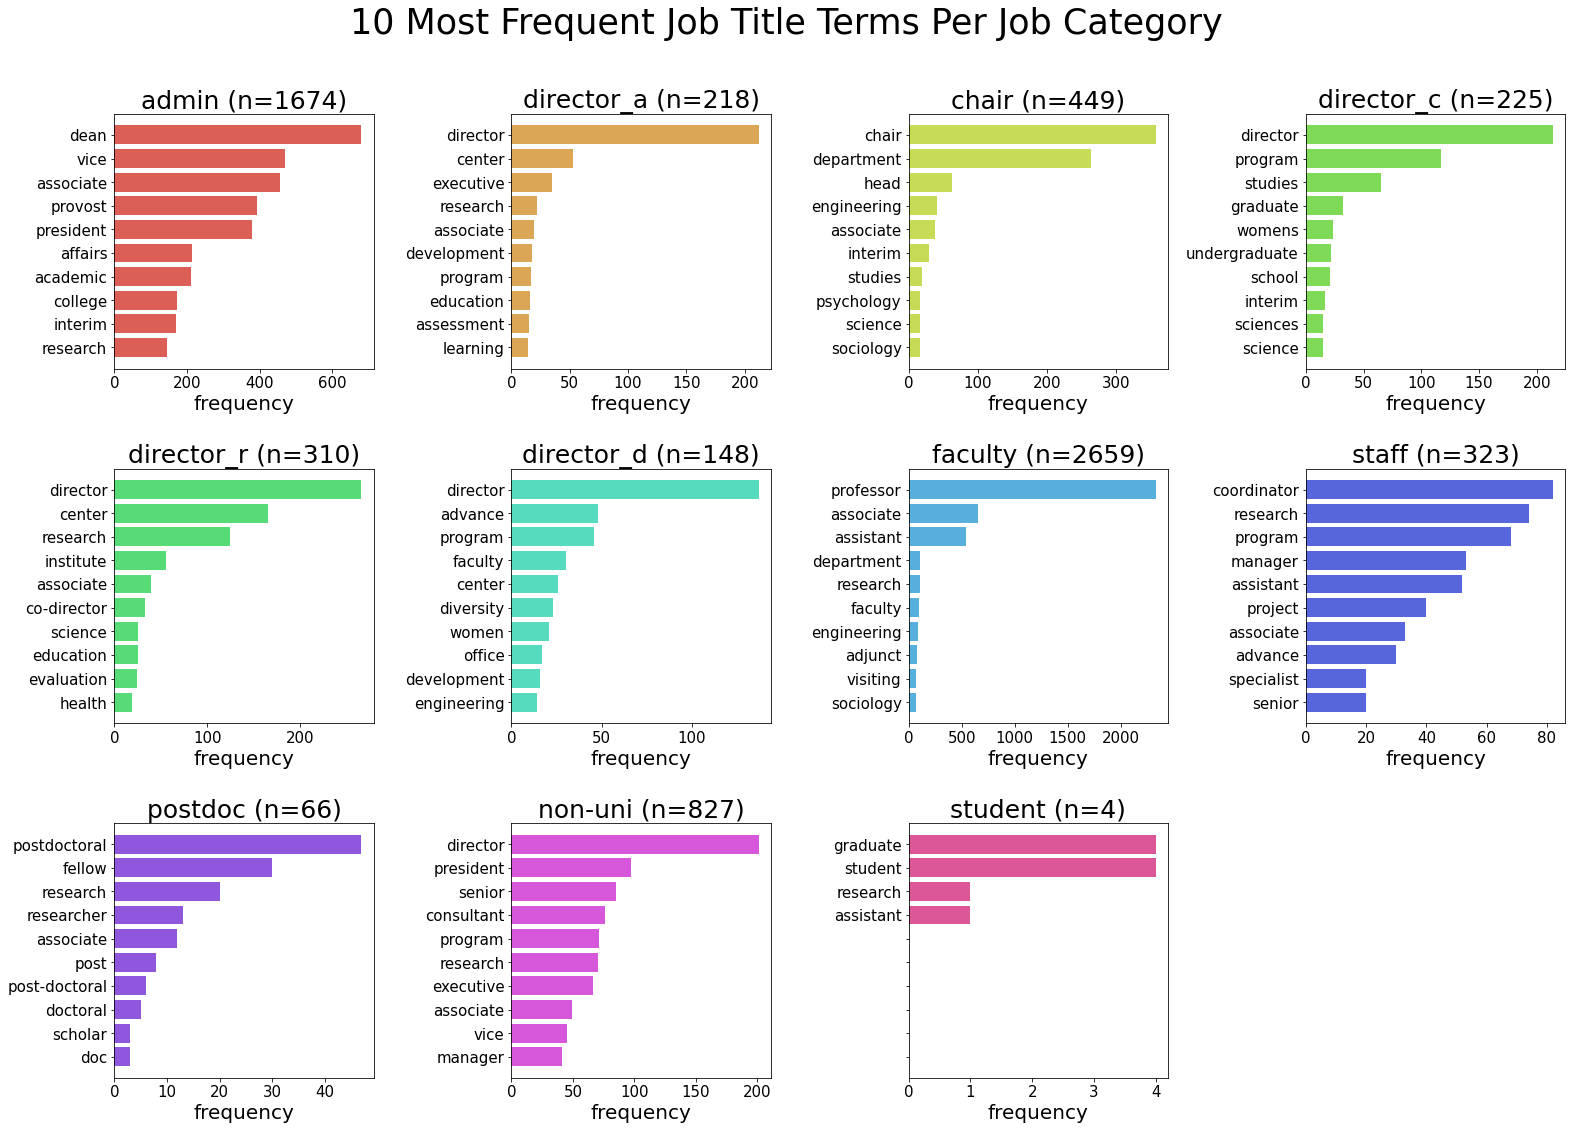

In [789]:
doc_jobs = viz_kmf(ind_jobs, 'job_category', 'job_title', job_cats, 10)

In [790]:
print(doc_jobs)


The 10 most frequent job title terms in each job category are:
admin (n=1674)
  - dean: 681
  - vice: 471
  - associate: 457
  - provost: 392
  - president: 380
  - affairs: 215
  - academic: 211
  - college: 173
  - interim: 170
  - research: 144
director_a (n=218)
  - director: 212
  - center: 53
  - executive: 35
  - research: 22
  - associate: 19
  - development: 18
  - program: 17
  - education: 16
  - assessment: 15
  - learning: 14
chair (n=449)
  - chair: 357
  - department: 264
  - head: 62
  - engineering: 41
  - associate: 38
  - interim: 29
  - studies: 19
  - psychology: 17
  - science: 17
  - sociology: 17
director_c (n=225)
  - director: 214
  - program: 117
  - studies: 65
  - graduate: 32
  - womens: 24
  - undergraduate: 22
  - school: 21
  - interim: 17
  - sciences: 15
  - science: 15
director_r (n=310)
  - director: 266
  - center: 165
  - research: 125
  - institute: 56
  - associate: 39
  - co-director: 33
  - science: 26
  - education: 25
  - evaluation: 24
  -

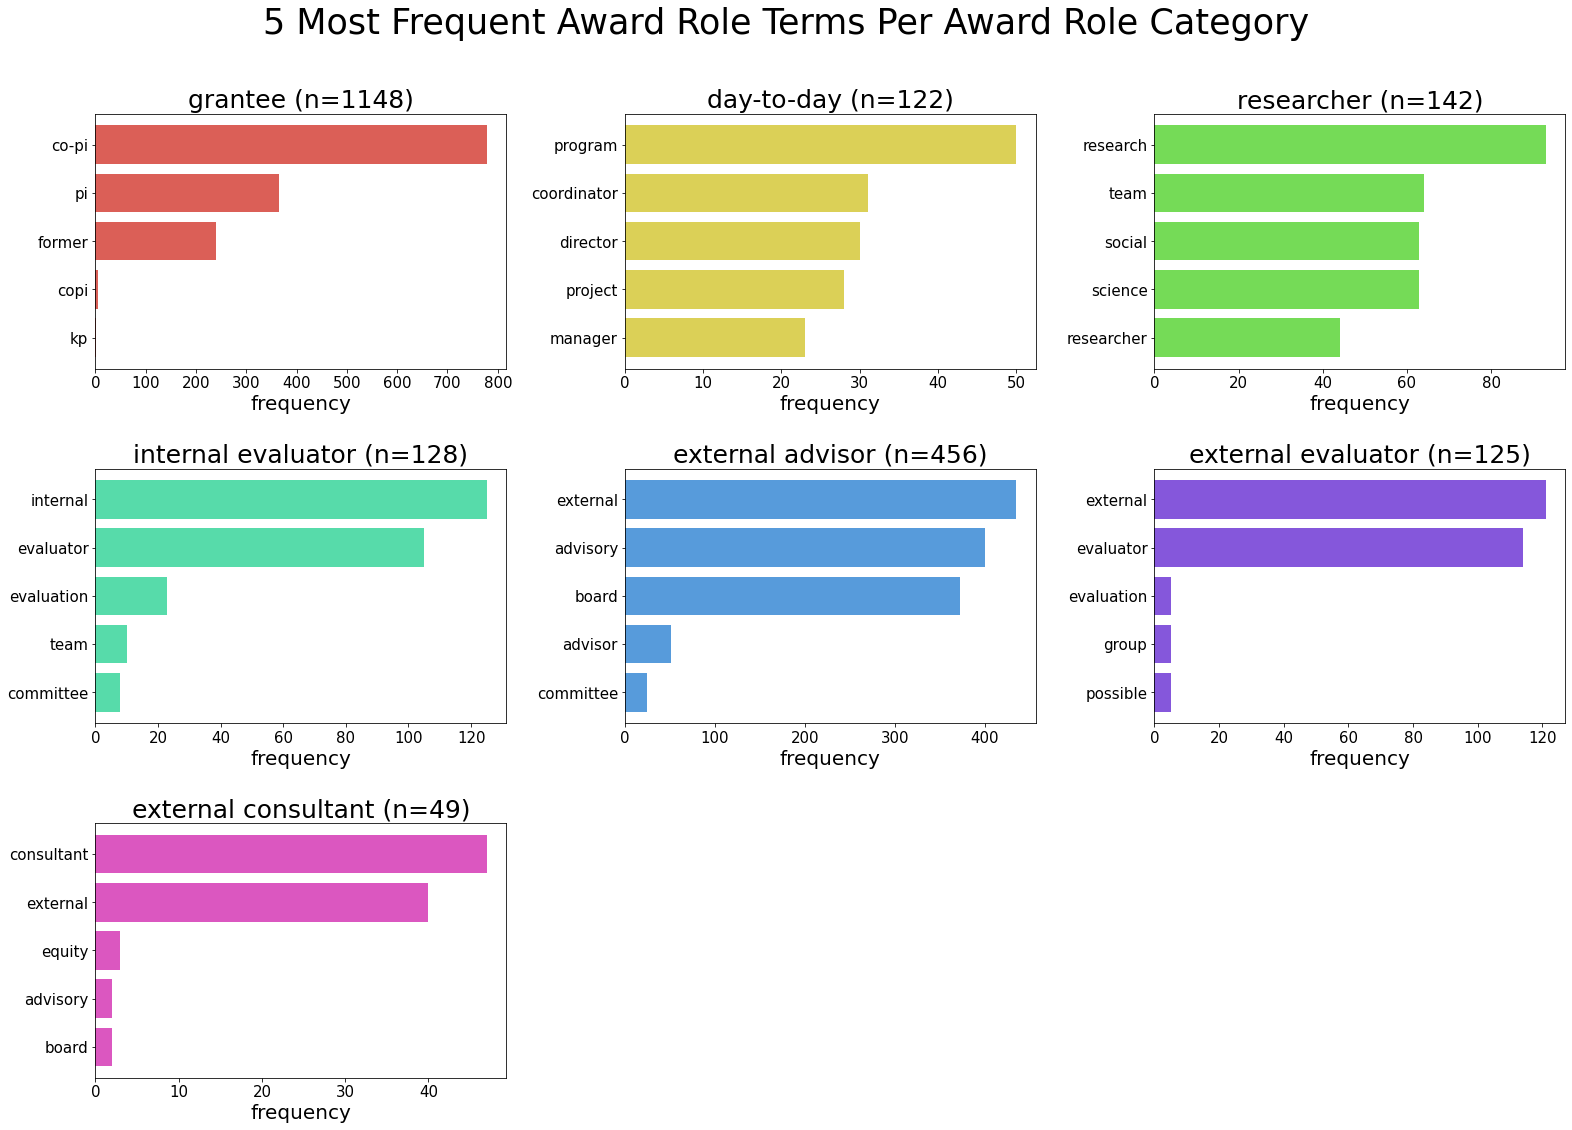

In [791]:
doc_roles = viz_kmf(ind_awards, 'award_role_cat', 'award_role', role_cats, 5)

In [792]:
print(doc_roles)


The 5 most frequent award role terms in each award role category are:
grantee (n=1148)
  - co-pi: 778
  - pi: 365
  - former: 239
  - copi: 5
  - kp: 2
day-to-day (n=122)
  - program: 50
  - coordinator: 31
  - director: 30
  - project: 28
  - manager: 23
researcher (n=142)
  - research: 93
  - team: 64
  - social: 63
  - science: 63
  - researcher: 44
internal evaluator (n=128)
  - internal: 125
  - evaluator: 105
  - evaluation: 23
  - team: 10
  - committee: 8
external advisor (n=456)
  - external: 435
  - advisory: 400
  - board: 373
  - advisor: 51
  - committee: 25
external evaluator (n=125)
  - external: 121
  - evaluator: 114
  - evaluation: 5
  - group: 5
  - possible: 5
external consultant (n=49)
  - consultant: 47
  - external: 40
  - equity: 3
  - advisory: 2
  - board: 2


---
---

<a id='two'></a>

# 2. Data Cleaning & Pre-Processing

Here, we clean the dataset for easier processing. This includes:

- **Trimming extra spaces.** (Leading, trailing, double consecutive)
- **Individual jobs' years and categories.** Since this is the main file we'll be looking at, we fill in missing year data with useful placeholders, and drop student/NaN job categories.
- **Labeling universities and non-universities** A university is defined as an institution with a Carnegie ID or whose name contains one of several keywords.

## 2.1 Space Trimming

In [793]:
# Trim the given dataframe, excluding the given list of columns
def trim_spaces(df, cols):
    df_exc = df.drop(cols, axis=1)
    cols = list(df_exc)
    
    for i, row in df.iterrows():
        for col in cols: # dataframe columns
            data = df[col][i] # get the ith element of column 
            if pd.isna(data):
                continue
            if isinstance(data, str):
                # Trim leading, trailing, and double-consecutive spaces
                trimmed = " ".join(data.split())  
                df.loc[i, col] = trimmed
                # if (data != trimmed):
                    # print(i, col, '\"' + data + '\" -> \"' + trimmed + '\"')

In [794]:
trim_spaces(ind_jobs, ['bio_urls', 'combined_comments'])
trim_spaces(ind_awards, [])
trim_spaces(ind_demographics, [])
trim_spaces(orgs, [])

## 2.2 Individal Jobs Cleaning

We perform two sets of operations on the individual jobs file: the first should be reused for exporting the final individual jobs file later, and the second is only for this job processing task.

First, we delete the jobs whose job category is student, as these should not exist in the dataset. 

Then, for job processing, we drop jobs which are missing a job category, or whose category is non-uni, and convert the missing start/end years in the individual jobs dataframe to min/max values.

Note: Because of this, jobs without start years are considered non-lower-bounded and jobs without end years are considered non-upper-bounded. This allows us to consider positions that are missing this info when determining temporally relative position information.

In [795]:
def drop_students():
    before = len(ind_jobs)
    c_stud = 0
    body_stud = ''

    for i, row in ind_jobs.iterrows():
        cat = row['job_category']
        
        if cat == 'student':
            ind_jobs.drop(i, inplace=True)
            body_stud += 'person ' + str(row['person_id']) + ' has a student position in row ' + str(i) + '\n'
            list_student.append(row['person_id'])
            c_stud += 1

    ind_jobs.reset_index(inplace=True)

    out('\n' + str(c_stud) + ' students dropped for the jobs processing task.')
    out(' ')
    [out(line) for line in body_stud.splitlines()]

In [796]:
def clean_ind_jobs():
    before = len(ind_jobs)
    c_nan = 0
    c_start = 0
    c_end = 0
    body_nan = ''

    for i, row in ind_jobs.iterrows():
        cat = row['job_category']
        start = row['job_start_year']
        end = row['job_end_year']

        if pd.isna(cat):
            ind_jobs.drop(i, inplace=True)
            body_nan += 'person ' + str(row['person_id']) + ' has a no-category position in row ' + str(i) + '\n'
            list_nan.append(row['person_id'])
            c_nan += 1
            continue
        if pd.isna(start) or not str(int(start)).isnumeric():
            ind_jobs.loc[i, 'job_start_year'] = 0
            c_start += 1
        if pd.isna(end) or not str(end).isnumeric():
            ind_jobs.loc[i, 'job_end_year'] = 3000
            c_end += 1

    ind_jobs.reset_index(inplace=True)
    ind_jobs['job_start_year'] = pd.to_numeric(ind_jobs['job_start_year'])
    ind_jobs['job_end_year'] = pd.to_numeric(ind_jobs['job_end_year'])

    out('\n' + str(c_nan) + ' no-category positions dropped for the jobs processing task.')
    out(str(c_start) + ' start years were set to 0.')
    out(str(c_end) + ' end years were set to 3000.')
    out(' ')
    [out(line) for line in body_nan.splitlines()]

In [797]:
section(3, 'Student and NaN Job Categories')
drop_students()
out('\nThe jobs/demographics and individual awards for the individuals with student positions are located in:')
out('> log_student_jobs.csv, log_student_awards.csv\n')
out(LINE)
clean_ind_jobs()
out('\nThe jobs/demographics and individual awards for the individuals with NaN-category positions are located in:')
out('> log_nan_jobs.csv, log_nan_awards.csv files.')


4 students dropped for the jobs processing task.
 
person 1604 has a student position in row 2788
person 1981 has a student position in row 4527
person 2254 has a student position in row 5489
person 2413 has a student position in row 6118

The jobs/demographics and individual awards for the individuals with student positions are located in:
> log_student_jobs.csv, log_student_awards.csv

------------------------------------------------------------------------------------------------------------------------

29 no-category positions dropped for the jobs processing task.
462 start years were set to 0.
2016 end years were set to 3000.
 
person 1019 has a no-category position in row 102
person 1045 has a no-category position in row 238
person 1049 has a no-category position in row 253
person 1079 has a no-category position in row 388
person 1090 has a no-category position in row 429
person 1143 has a no-category position in row 658
person 1162 has a no-category position in row 754
person 

## 2.3 University Labeling

#### We define an institution as a university if:
- It has a corresponding Carnegie ID
- It contains a university-related keyword (such as "university", "school")

#### A non-university:
- May contain an "antikey" (such as "school**s**", which is only used by associations of schools).
- May contain the word "institute". This can be either a non-uni or a uni term: Indian Institute of Technology, Mumbai (uni) versus Space Telescope Science Institute (non-uni). Thus, we mark it as non-uni for now, and these have to manually be marked as uni.

In [798]:
# Return whether the given employer id corresponds to a university
def is_uni(emp_id):
    if pd.isna(emp_id):
        out('NaN employer')
        return False
        
    # If the employer is not in our list of organizations, return false.
    if not emp_id in orgs['org_id'].unique():
        out(str(emp_id) + ' is not in the organizations CSV')
        return False
    
    # Get the row corresponding to the given id in the organizations df
    org = orgs[orgs['org_id'] == emp_id].iloc[0]
    name = org['org_name'].lower() 
    
    # If the org has a Carnegie ID, then it is a US university 
    if not pd.isna(org['carnegie_id']):
        # out(name + ' has a Carnegie ID, so it\'s a US uni')
        return True
    
    # For non-US universities, we have keywords that we look for in the org's name
    keys = ['university', 'college', 'school', 'universitat', 'universidad', 'ecole']
            
    # We also have keys for non-unis that contain our uni keys, so we check for these first
    # Ex. "Cambridge Public Schools"
    antikeys = ['colleges', 'schools', 'association']    
    if any(x in name for x in antikeys):
        # out(name + ' contains an antikey, so it is not a uni')
        return False
    
    if any(x in name for x in keys):
        # out(name + ' contains a uni key, so it\'s a non-US uni')
        return True
    
    # The most tricky term seems to be "institute", as it can be either a non-uni or a uni term.
    # From manual review, we can see three institutes which are universities; these are marked here.
    if 'institute' in name and ('india' in name or 'stockholm' in name):
        # out(name + ' contains \'institute\' so it may or may not be a uni')
        return True
    
    # Else the org is not a US or non-US uni; return False
    # out(name + ' is not a uni')
    return False

In [799]:
out('', False)
section(4, 'Universities vs. Non-Universities')

us_unis = 0 # Count of US universities
for i, row in orgs.iterrows():
    orgs.loc[i, 'is_uni'] = is_uni(row['org_id'])
    us_unis += 1 if not pd.isna(row['carnegie_id']) else 0

out('\nNOTE: The organizations file should be reviewed, since the ASME Board of Governors improperly has a Carnegie ID value,')
out('so there may be other errors in this data.\n')
unis = len(orgs[orgs['is_uni']==True])
out(str(unis) + ' organizations are programmatically marked as universities. Of these, ' + str(us_unis) + ' are US universities, and ' + str(unis-us_unis) + ' are non-US.')
out(str(len(orgs[orgs['is_uni']==False])) + ' organizations are programmatically marked as non-universities. These will be ignored in the jobs processing task.')


NOTE: The organizations file should be reviewed, since the ASME Board of Governors improperly has a Carnegie ID value,
so there may be other errors in this data.

736 organizations are programmatically marked as universities. Of these, 620 are US universities, and 116 are non-US.
624 organizations are programmatically marked as non-universities. These will be ignored in the jobs processing task.


---
---

<a id='three'></a>

# 3. Error Detection

We have a few potential errors we want to locate in the dataset. These include:
- **University jobs at non-universities.** In the invididual jobs file, positions should be marked as non-uni if the employer is not a university as defined in 2.3.
- **Date issues**. Start years must be <= end years for awards/jobs; jobs associated with the director of ADVANCE cannot start before the grant year.
- **Job category placement.** We predict errors in job category placement based on job title terminology.

## 3.1 University Jobs at Non-Universities 

We add to the report each non-university which has at least one employee with a university-labeled position, and set the listed position(s)' category to non-uni.

In [800]:
print('\nThe employers for the below positions are not presently marked as universities, so their categories will be set to non-uni.')

def mark_non_uni_jobs():
    body_uni = ''
    # If a job position is NOT marked as non-uni AND the corresponding employer is NOT a uni (by our definition)
    # Then there is an error -- the job should be marked as non-uni, since the employer is not a university.
    for i, row in orgs.iterrows():
        if row['is_uni'] == False:
            employees = ind_jobs[(ind_jobs['employer_id'] == row['org_id']) 
                                & (ind_jobs['job_category'] != 'non-uni')]
            if (len(employees) != 0):
                body_uni += '\n' + str(int(row['org_id'])) + ': ' + row['org_name']
                for i, row in employees.iterrows():
                    body_uni += '\n - ' + str(int(row['person_id'])) + ' had uni position: ' + row['job_category']
                    ind_jobs.loc[(ind_jobs['person_id']==row['person_id'])
                                 & (ind_jobs['job_title']==row['job_title'])
                                 & (ind_jobs['employer_id'] == row['employer_id']), 'job_category'] = 'non-uni'
    return body_uni

before = len(ind_jobs[ind_jobs['job_category']=='non-uni'])
body_uni = mark_non_uni_jobs()
after = len(ind_jobs[ind_jobs['job_category']=='non-uni'])
print('Number of jobs newly set to non-uni: ' + str(after-before))
print(body_uni)


The employers for the below positions are not presently marked as universities, so their categories will be set to non-uni.
Number of jobs newly set to non-uni: 111

276732762: AAAS Education Program
 - 2496 had uni position: director_a
2255342618: Agilent Technologies
 - 2163 had uni position: admin
1991545139: American Association for Higher Education
 - 2497 had uni position: admin
4105696068: American Association for the Advancement of Science
 - 2495 had uni position: director_r
3532741284: American Association of Colleges of Pharmacy
 - 1542 had uni position: admin
1508303019: American Educational Research Association
 - 2145 had uni position: director_a
2653734887: American Institute of Physics
 - 1859 had uni position: director_r
 - 1859 had uni position: director_r
 - 1859 had uni position: director_r
39548561: American Society for Engineering Education
 - 1381 had uni position: admin
2628653055: Area Education Agency
 - 2490 had uni position: faculty
204489729: Association F

## 3.2 Date Evaluation

In [801]:
# Since there's no output here, we can see that all job start years are less than their end years
for i, row in ind_jobs.iterrows():
    if row['job_start_year'] > row['job_end_year']:
        print(i)

In [802]:
out('', False)
section(5, 'Individual Award Date Issues')
out('\nThese individuals have at least one job associated with being director of an ADVANCE program which starts before they') 
out('entered the network.\n')

for i, row_job in ind_jobs.iterrows():
    # row_job['job_category'] == 'director_d'
    job_start = row_job['job_start_year']
    if job_start == 0:
        continue
    title = row_job['job_title'].lower()
    if (title.endswith('advance') or 'advance ' in title) and 'director' in title:
        valid_director_job = False
        awards_slice = get_awards(row_job['person_id'])
        for i, row_award in awards_slice.iterrows():
            if job_start >= row_award['award_start_year']:
                valid_director_job = True
        if not valid_director_job:
            award_year = awards_slice['award_start_year'][awards_slice.index[0]]
            award_org = str(int(awards_slice['award_org_id'][awards_slice.index[0]]))
            title = title[:60] + '...' if len(title) > 60 else title
            out('Person ' + str(row_job['person_id'])
                  + ' has a job as \"' + title
                  + '\" which starts in year ' + str(int(job_start)) + '.')
            out('> Their first award started in ' + str(int(award_year)) + ' at org ' + award_org + '.')


These individuals have at least one job associated with being director of an ADVANCE program which starts before they
entered the network.

Person 1001 has a job as "director of the university of michigan advance program" which starts in year 1995.
> Their first award started in 2002 at org 44098792.
Person 1722 has a job as "director of lehigh's nsf-advance grant" which starts in year 2013.
> Their first award started in 2015 at org 1213318465.
Person 2110 has a job as "associate director, advance program" which starts in year 2011.
> Their first award started in 2012 at org 4012281303.
Person 2210 has a job as "acting director, advance program" which starts in year 2012.
> Their first award started in 2018 at org 1397069697.
Person 2210 has a job as "associate director, advance program, and director of the adv..." which starts in year 2014.
> Their first award started in 2018 at org 1397069697.
Person 2210 has a job as "director, advance program" which starts in year 2016.
> Their f

## 3.3 Prediction of Job Category Misplacement

We seek to detect in this section job category misplacement via our k-most-frequent algorithm, and through searching for category-specific keys and antikeys. 

For example, we expect administrators to fall into high-level positions such as dean and provost, so we want to mark for manual review those positions marked admin which contain such terms as "advisor" and "liaison", as these aren't top-level administrative positions.

In [803]:
job_cats_task = job_cats.copy()
job_cats_task.remove('non-uni')
job_cats_task.remove('student')
sort_jobs(job_cats_task)

freq_dict = {cat: k_most_freq(ind_jobs, 'job_category', 'job_title', cat, 15) for cat in job_cats_task}

In [804]:
keys_dict = {'admin': ['chief', 'ceo'],
             'director_a': [],
             'chair': ['chairman'],
             'director_c': [],
             'director_r': [],
             'director_d': [],
             'faculty': ['lecturer', 'scientist', 'instructor'],
             'staff': ['research', 'researcher', 'advisor'],
             'postdoc': ['postdoc']}

antikeys_dict = {'admin': ['advisor', 'liaison'],
             'director_a': ['advisor', 'liaison'],
             'chair': [],
             'director_c': [],
             'director_r': [],
             'director_d': [],
             'faculty': [],
             'staff': [],
             'postdoc': []}

In [805]:
out('', False)
section(6, 'Predicting Job Category Misplacement')
out('\nFor each category, we output the job titles which contain neither the 15 most frequent terms in their assigned category nor '
    + 'any of the manually defined category keys. This also points to some misspelled job titles, such as \"profesor\".')

for cat in job_cats_task:
    keys = [tup[0] for tup in freq_dict[cat]]
    keys = keys + keys_dict[cat]
    antikeys = antikeys_dict[cat]
    cat_slice = ind_jobs.loc[ind_jobs['job_category'] == cat]
    
    out('\nJob titles which may not fit in category ' + cat + ': ')
    for i, row in cat_slice.iterrows():
        terms = re.split(',|, |_|-| |:|/', row['job_title']) 
        if (not any(term in keys for term in terms)) or any(term in antikeys for term in terms):
            out('Person ' + str(int(row['person_id'])) + ': ' + row['job_title'])


For each category, we output the job titles which contain neither the 15 most frequent terms in their assigned category nor any of the manually defined category keys. This also points to some misspelled job titles, such as "profesor".

Job titles which may not fit in category admin: 
Person 1018: special advisor to the president
Person 1021: organizational change management director
Person 1052: special advisor to the vice-president academic on faculty development
Person 1053: special advisor to provost for gender
Person 1071: professor
Person 1121: wellness programs administrator
Person 1130: prem program director
Person 1131: deputy director
Person 1167: advisor to the president
Person 1198: budget director
Person 1239: director, the ethos center
Person 1343: ciesin senior fellow
Person 1357: director and professor of statistics
Person 1386: senior advisor
Person 1386: senior advisor to the president
Person 1389: special advisor on research development and external partnerships
Pers

---
---

<a id='four'></a>

# 4. Locating First, Highest, and Latest Positions

In [806]:
# First, we're going to filter out the non-university positions

non_unis = len(ind_jobs[ind_jobs['job_category']=='non-uni'])

for i, row in ind_jobs.iterrows():
    if row['job_category'] == 'non-uni':
        ind_jobs.drop(i, inplace=True)
        
#ind_jobs.reset_index(inplace=True)
print('We dropped ' + str(non_unis) + ' non-university positions.')

We dropped 938 non-university positions.


In [807]:
# Get the year and job of the given person when they first entered the ADVANCE network (via the first grant they worked on)
# Input: an individual's id, the year of the person's first grant they worked on, and the institution of their first grant
# Return the first job and first year in the network of the given person
def get_first_job(p_id, year, e_id):
    # Get the jobs for this p_id at the given e_id where all job years are leq the award start year
    jobs_slice = ind_jobs.loc[(ind_jobs['person_id'] == p_id)
                              & (ind_jobs['job_start_year'] - year <= 0)
                              & (ind_jobs['job_end_year'] - year >= 0)
                              & (ind_jobs['employer_id'] == e_id)].sort_values(by = 'job_start_year') 
    ind = -1
    # We're getting the job they had when they entered the network (start of grant)
    # So we want the closest job they had to the start year of the grant
    
    # If there are no jobs found which started on or before the grant start year, get the first job at the institution    
    if len(jobs_slice) == 0:                
        jobs_slice = ind_jobs.loc[(ind_jobs['person_id'] == p_id)
                                  & (ind_jobs['employer_id'] == e_id)].sort_values(by = 'job_start_year')
        ind = 0 # First job
       
        # If there are no jobs at the first award institution, find the closest (<=) job to the first award's start year
        if len(jobs_slice) == 0:
            jobs_slice = ind_jobs.loc[(ind_jobs['person_id'] == p_id)
                                      & (ind_jobs['job_start_year'] - year <= 0)
                                      & (ind_jobs['job_end_year'] - year >= 0)].sort_values(by = 'job_start_year') 
            ind = -1 # Last row has closest job 
                    # If still no jobs, return NaN
    
            # If there are no jobs <= the award start year, just get the highest job for this person
            if len(jobs_slice) == 0:
                jobs_slice = get_jobs(p_id)
                                
                # If there are still no jobs, return NaN
                if (len(jobs_slice) == 0):
                    return (np.nan, np.nan)
                
                else: # This person has at least one job; get the highest one
                    jobs_list = jobs_slice['job_category'].drop_duplicates().to_list()
                    jobs_list = [x for x in jobs_list if str(x) != 'nan']
                    highest_title = get_highest_title(jobs_list)
                    # We assume that they entered the ADVANCE network in the grant start year
                    return (highest_title, year)
       
    # Ascending order --> take either the jobs in the first year or the last one (if need leq closest to award year)
    first_year_in_ADVANCE = jobs_slice['job_start_year'][jobs_slice.index[ind]]

    # Get all rows in the dataframe slice that contain the first year
    jobs_first_year_slice = jobs_slice.loc[ind_jobs['job_start_year'] == first_year_in_ADVANCE]

    # Find the highest position of all the first-year jobs
    jobs_list = jobs_first_year_slice['job_category'].drop_duplicates().to_list()
    jobs_list = [x for x in jobs_list if str(x) != 'nan']
    highest_title = get_highest_title(jobs_list)
    return (highest_title, first_year_in_ADVANCE)

In [808]:
# Get the job of the given person after they entered the ADVANCE network (via the first grant they worked on)
# Input: an individual's id, the year of the person's first grant they worked on, and (optionally) an employer id to filter by
def get_highest_job(p_id, e_id=True):
  
    first_year_in_advance = log_individual_jobs.loc[log_individual_jobs['person_id'] == p_id, 
                                                    'first_year_in_advance'].iloc[0]
    
    # First, get the jobs they had at their award institutions after entering the ADVANCE network
    if e_id: # If e_id=True then no filtering by employer id
        inst = get_awards(p_id)['award_org_id'].unique()
        jobs = ind_jobs[(ind_jobs['person_id'] == p_id) 
                        & (ind_jobs['job_start_year'] >= first_year_in_advance)
                        & (ind_jobs['employer_id'].isin(inst))]
    else:
        jobs = ind_jobs[(ind_jobs['person_id'] == p_id) & (ind_jobs['employer_id'] == e_id)]
    
    # If there are none, then just get the jobs they had after they entered the ADVANCE network 
    if len(jobs) == 0:
        jobs = ind_jobs[(ind_jobs['person_id'] == p_id) & (ind_jobs['job_start_year'] >= first_year_in_advance)]
        
        # If they have no jobs after entering the network, then just get the highest job that this person ever had
        if len(jobs) == 0:
            jobs = ind_jobs[ind_jobs['person_id'] == p_id]
            
            # If still no jobs, return NaN
            if len(jobs) == 0: 
                return np.nan
    
    jobs_list = jobs['job_category'].drop_duplicates().to_list()
    jobs_list = [x for x in jobs_list if str(x) != 'nan']
    return get_highest_title(jobs_list)

In [809]:
# Get the most recent job of the given individual, or the highest most recent in the case of ties
# Input: an individual's id, and (optionally) a max year to filter by
def get_last_job(p_id, year=3000):
    jobs_slice = get_jobs(p_id)
    if len(jobs_slice) == 0:
        return np.nan
    jobs_slice_leq = jobs_slice[jobs_slice['job_start_year'] <= year].copy()
    if len(jobs_slice_leq) > 0:
        jobs_slice = jobs_slice_leq
    last_start_year = jobs_slice['job_start_year'][jobs_slice.index[-1]]
    jobs_last_start_year = jobs_slice.loc[ind_jobs['job_start_year'] == last_start_year].sort_values('job_end_year')
    jobs_list = jobs_last_start_year['job_category'].drop_duplicates().to_list()
    jobs_list = [x for x in jobs_list if str(x) != 'nan']
    return get_highest_title(jobs_list)   

In [810]:
# Output a breakdown of the given log df (level = a string title for the data in the df)
def out_log_task_breakdown(df, level):
    missing = df[(df['first_job'].isna())
                 | (df['highest_job'].isna())
                 | (df['last_job'].isna())].copy()

    n = len(df)
    missing_any = len(missing)
    missing_first = df['first_job'].isna().sum()
    missing_highest = df['highest_job'].isna().sum()
    missing_last = df['last_job'].isna().sum()

    perc_filled = 100-(100*missing_any/n)
    perc_first = 100*(missing_first)/n
    perc_highest = 100*(missing_highest)/n
    perc_last = 100*(missing_last)/n

    # Analysis for individuals with found data -----------------------------------------------

    out('\nFound first, highest, and last positions for ' + f'{perc_filled:.2g}%' + ' of the ' + str(n) + ' ' + level + ' in our records. (n=' + str(n - missing_any) + ')')

    # print(str(ties) + ' individuals have more than one award in their first year in the ADVANCE Program.') 
    # print(doc_tie) for a list of these individuals

    def out_job_breakdown(col):
        for cat in job_cats_task:
            # Get the number of individuals whose given position were in this category
            count = len(df[df[col] == cat].copy())
            perc = 100*count/(n-missing_any)
            out(f'{perc:.1f}% ' + cat + ' positions (n=' + str(count) + ')')
    
    out('\nThe first jobs of these ' + level + ' are:')
    out_job_breakdown('first_job')
    out('\nThe highest jobs of these ' + level + ' are:')
    out_job_breakdown('highest_job')
    out('\nThe last jobs of these ' + level + ' are:')
    out_job_breakdown('last_job')

    # Analysis for individuals missing data -----------------------------------------------

    out(' ')
    out(LINE)
    out(' ')
    if (missing_first == missing_highest == missing_last): 
        out(str(missing_any) + ' ' + level + ' are missing first, highest, and last positions.')
    else:
        out(str(missing_first) + ' ' + level + ' are missing first positions out of ' +
              str(n) + ' ' + level + '. ' + f'({perc_first:.2g}% filled)')
        out(str(missing_highest) + ' ' + level + ' are missing highest positions out of ' +
              str(n) + ' ' + level + '. ' + f'({perc_highest:.2g}% filled)')
        out(str(missing_last) + ' ' + level + ' are missing last positions out of ' + 
              str(n) + ' ' + level + '. ' + f'({perc_last:.2g}% filled)')

    # Get the people who are missing data in at least one of the job categories 
    out('\nOf the ' + str(missing_any) + ' ' + level + ' missing at least one of these positions,')

    # Of those, see how many people have no non-uni/student/NaN jobs
    no_jobs = 0
    for i, row in missing.iterrows():
        jobs = get_jobs(row['person_id'])
        if len(jobs) == 0:
            no_jobs += 1
    no_jobs_perc = 100*no_jobs/missing_any
    out(f'{no_jobs_perc:.3g}%' + ' have zero jobs which are not categorized as non-uni/student/NaN. (n=' + str(no_jobs) + ')')   

    # Get all the awards for those individuals, and output distribution of award roles
    awards_missing_ind = ind_awards[ind_awards['person_id'].isin(missing['person_id'])]
    
    for cat in role_cats:
        # Get the number of individuals who had at least one position in this award role category
        cat_awards_slice = awards_missing_ind[awards_missing_ind['award_role_cat'] == cat].copy().drop_duplicates('person_id')
        cat_count = len(cat_awards_slice)
        cat_perc = 100*cat_count/missing_any
        out(f'{cat_perc:.2g}%' + ' have at least one ' + cat + ' award role. (n=' + str(cat_count) + ')')

## 4.1 Person Level

Given the cleaned dataset, we find first, highest, and latest positions for 100% of individuals with at least one categorizable, non-university position. We output a set of 74 individuals (5% of overall) whose records necessitate further research.

In [811]:
# For each individual, get the first, highest, and last jobs

ties = 0
doc_tie = ''

for i, row in log_individual_jobs.iterrows():
    p_id = row['person_id']
    awards_slice = get_awards(p_id)
    
    # Ascending order --> first row has year and institution of the first award this person worked on
    ind_first = awards_slice.index[0]
    year_first = awards_slice['award_start_year'][ind_first]
    
    # If individuals started at two different grants in the same years, pick the one where they had the highest role
    awards_year_first = awards_slice.loc[awards_slice['award_start_year'] == year_first].copy()
    awards_year_first.drop_duplicates('award_org_id', inplace=True)
    if len(awards_year_first) > 1:
        awards_year_first['award_role_cat'] = awards_year_first['award_role_cat'].map(role_dict).argsort()
        e_id_first = awards_year_first['award_org_id'][awards_year_first.index[-1]]
        # doc_tie += 'Person ' + str(p_id) + '\'s highest role was at org ' + str(e_id_first) + '\n'
        ties += 1
    else: 
        e_id_first = awards_slice['award_org_id'][ind_first]
    
    # Get the highest first position at the first institution, and the first year in the network
    tup_first = get_first_job(p_id, int(year_first), e_id_first)
        
    log_individual_jobs.loc[i, 'first_year_in_advance'] = tup_first[1]
    log_individual_jobs.loc[i, 'first_job'] = tup_first[0]
    log_individual_jobs.loc[i, 'highest_job'] = get_highest_job(p_id, year_first)
    log_individual_jobs.loc[i, 'last_job'] = get_last_job(p_id)

In [812]:
out('', False)
section(7, 'Location of First, Highest, and Last Jobs')
out_log_task_breakdown(log_individual_jobs, 'individuals')
out('\nThe jobs/demographics and individual awards for the individuals missing positions are located in:')
out('> log_missing_jobs.csv, log_missing_awards.csv')


Found first, highest, and last positions for 95% of the 1590 individuals in our records. (n=1516)

The first jobs of these individuals are:
27.7% admin positions (n=420)
3.6% director_a positions (n=55)
8.0% chair positions (n=122)
3.2% director_c positions (n=49)
5.1% director_r positions (n=77)
3.5% director_d positions (n=53)
41.0% faculty positions (n=621)
7.3% staff positions (n=110)
0.6% postdoc positions (n=9)

The highest jobs of these individuals are:
36.8% admin positions (n=558)
5.9% director_a positions (n=90)
8.5% chair positions (n=129)
3.6% director_c positions (n=54)
5.3% director_r positions (n=80)
3.5% director_d positions (n=53)
29.9% faculty positions (n=453)
5.9% staff positions (n=90)
0.6% postdoc positions (n=9)

The last jobs of these individuals are:
30.9% admin positions (n=468)
4.4% director_a positions (n=66)
7.7% chair positions (n=116)
2.8% director_c positions (n=43)
5.5% director_r positions (n=84)
2.6% director_d positions (n=40)
39.2% faculty position

## 4.2 Role Level

In [813]:
# For each individual award role, get the first, highest, and last jobs

for i, row in log_individual_awards.iterrows():
    # Get all the award role categories this person had for this award, and pick the highest
    awards_slice = get_awards(row['person_id'])
    awards_org_slice = awards_slice[(awards_slice['award_id'] == row['award_id'])] 
    roles_list = awards_org_slice['award_role_cat'].drop_duplicates().to_list()
    roles_list = [x for x in roles_list if str(x) != 'nan']
    log_individual_awards.loc[i, 'award_role_cat'] = get_highest_role(roles_list)

    # Get the first award role title which corresponds to this award role category
    first_highest_title = awards_org_slice['award_role'].drop_duplicates().to_list()[0]
    log_individual_awards.loc[i, 'award_role'] = first_highest_title
        
for i, row in log_individual_awards.iterrows():
    p_id = row['person_id']
    year = row['award_start_year']
    log_individual_awards.loc[i, 'first_job'] = get_first_job(p_id, year, row['award_org_id'])[0]
    log_individual_awards.loc[i, 'highest_job'] = get_highest_job(p_id, row['award_org_id'])
    log_individual_awards.loc[i, 'last_job'] = get_last_job(p_id, year)

In [814]:
out(' ', False)
out(LINE, False)
out_log_task_breakdown(log_individual_awards, 'individual award roles')


Found first, highest, and last positions for 95% of the 2024 individual award roles in our records. (n=1932)

The first jobs of these individual award roles are:
28.6% admin positions (n=553)
4.2% director_a positions (n=82)
8.0% chair positions (n=155)
2.6% director_c positions (n=51)
5.1% director_r positions (n=99)
4.7% director_d positions (n=90)
39.8% faculty positions (n=769)
6.4% staff positions (n=124)
0.5% postdoc positions (n=9)

The highest jobs of these individual award roles are:
38.4% admin positions (n=741)
6.3% director_a positions (n=122)
8.0% chair positions (n=155)
3.3% director_c positions (n=63)
4.9% director_r positions (n=95)
4.5% director_d positions (n=87)
29.2% faculty positions (n=565)
4.9% staff positions (n=95)
0.5% postdoc positions (n=9)

The last jobs of these individual award roles are:
29.3% admin positions (n=566)
4.1% director_a positions (n=80)
8.2% chair positions (n=159)
2.8% director_c positions (n=54)
5.2% director_r positions (n=100)
4.2% dire

## 4.3 Visualization of Job Categories

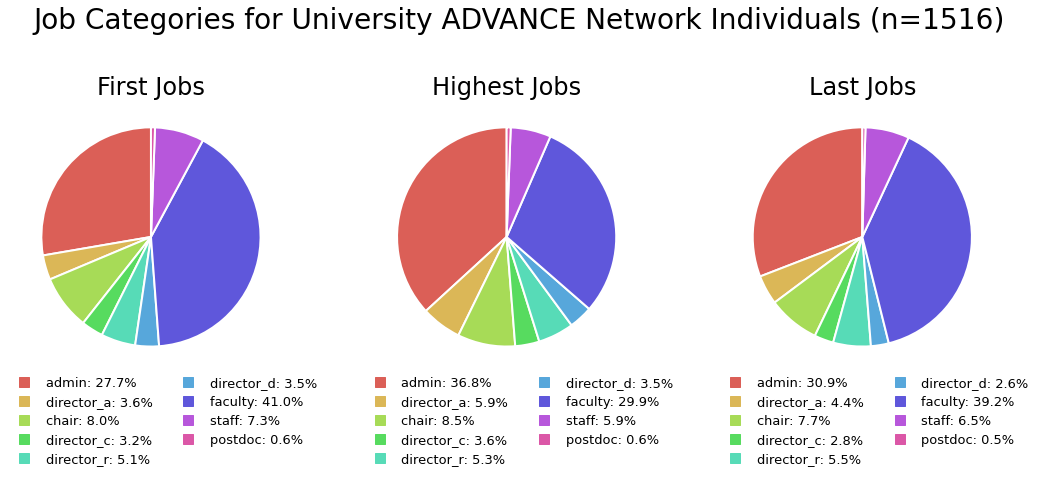

In [815]:
levels = ['first', 'highest', 'last']
COLORS = sns.color_palette("hls", len(job_cats_task))
TEXT_COLOR = 'black'
c = 1
fig = plt.figure(figsize=(15,7))

for level in levels:
    # Create a new dataframe to store the quantities of each subbar
    df_q = pd.DataFrame(columns=['cat', 'total'])

    # Add the quantity of each category to the quantity dataframe
    for cat in job_cats_task:
        total = len(log_individual_jobs[log_individual_jobs[(level + '_job')] == cat].copy())
        df_q = df_q.append({'cat': cat, 'total': total},ignore_index=True)

    def format_label(cat):
        count = df_q.loc[df_q['cat']==cat, 'total'].iloc[0]
        perc = 100*count/df_q['total'].sum()
        return cat + f': {perc:.1f}%'
        
    # Graph this category as a subplot
    ax = plt.subplot(1, 3, c)
    plt.title(level.title() + ' Jobs', fontsize=24, color=TEXT_COLOR)

    texts = ax.pie(df_q['total'], colors=COLORS, startangle=90, wedgeprops=dict(linewidth=2, edgecolor='w'))
    plt.rcParams['font.size'] = 12
    plt.rcParams['text.color'] = TEXT_COLOR

    # Make the legend
    custom_lines = [Line2D([0], [0], color=c, marker="s", markersize=10, linewidth=0, label=format_label(lab)) for c, lab in zip(COLORS, df_q['cat'])]
    leg = plt.legend(handles=custom_lines, loc="center", ncol=2, framealpha=0, bbox_to_anchor=(0.55, -0.17))
    for text in leg.get_texts():
        plt.setp(text, color = TEXT_COLOR, fontsize=13)
    
    c += 1

fig.suptitle("Job Categories for University ADVANCE Network Individuals " + "(n=" + str(sum(df_q['total'])) + ")", fontsize=28)
plt.tight_layout(rect=(0, 0, 1, 0.998))
plt.savefig('viz_log_individual_jobs.png')
plt.show()

# FINAL OUTPUT

In [816]:
# Reload and trim spaces for ind job
ind_jobs = pd.read_csv(inp_ipynb + 'individual_jobs.csv')
trim_spaces(ind_jobs, ['bio_urls', 'combined_comments'])

missing = log_individual_jobs[(log_individual_jobs['first_job'].isna())
                              | (log_individual_jobs['highest_job'].isna())
                              | (log_individual_jobs['last_job'].isna())].copy()
# Replace 0 years with np.nan
log_individual_jobs['first_year_in_advance'] = log_individual_jobs['first_year_in_advance'].replace([0], np.nan)

list_missing = missing['person_id'].to_list()
for p_id in list_missing:
    log_missing_dems = log_missing_dems.append(get_dems(p_id)) 
    log_missing_jobs = log_missing_jobs.append(get_jobs(p_id)) 
    log_missing_awards = log_missing_awards.append(get_awards(p_id))

for p_id in list_student:
    log_student_dems = log_student_dems.append(get_dems(p_id)) 
    log_student_jobs = log_student_jobs.append(get_jobs(p_id))
    log_student_awards = log_student_awards.append(get_awards(p_id))

for p_id in list_nan: 
    log_nan_dems = log_nan_dems.append(get_dems(p_id)) 
    log_nan_jobs = log_nan_jobs.append(get_jobs(p_id))
    log_nan_awards = log_nan_awards.append(get_awards(p_id))

In [817]:
log_individual_jobs.to_csv('log_individual_jobs.csv', index=False)
log_individual_awards.to_csv('log_individual_awards.csv', index=False)

log_missing_dems.to_csv('log_missing_dems.csv', index=False)
log_missing_jobs.to_csv('log_missing_jobs.csv', index=False)
log_missing_awards.to_csv('log_missing_awards.csv', index=False)

log_student_dems.to_csv('log_student_dems.csv', index=False)
log_student_jobs.to_csv('log_student_jobs.csv', index=False)
log_student_awards.to_csv('log_student_awards.csv', index=False)

log_nan_dems.to_csv('log_nan_dems.csv', index=False)
log_nan_jobs.to_csv('log_nan_jobs.csv', index=False)
log_nan_awards.to_csv('log_nan_awards.csv', index=False)

## Log Task Report File

In [818]:
read()

------------------------------------------------------------------------------------------------------------------------
ADVANCE Network Log Task Report
Generated 01/04/2021 00:50:33 EST by Mara Hubelbank
------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------
Section 1: Dataset Rundown
------------------------------------------------------------------------------------------------------------------------

Our current dataset includes:
1360 organizations
273 awards
1590 individuals
2170 individual award roles
6932 individual jobs

Between these, there are:
195 grant-receiving organizations
1590 individuals with at least one award role
1.4 award roles per individual, on average
7 award role categories
112 unique award role titles (before processing)
11 job categories
3410 unique job titles (before proc

In [4]:
import seaborn as sns
sns.color_palette("hls", 40) # get a distinct color for each category


[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.4492, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6052, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.8028, 0.86, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.6467999999999998, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.4907999999999996, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.34520000000000006),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.6572000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.86, 0.8132000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.339999999999999